In [121]:
# load第三方库
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [122]:
# 读入数据
train_p1 = pd.read_csv("../input/训练数据集1.csv")
train_p2 = pd.read_csv("../input/训练数据集2.csv")
train_p3 = pd.read_csv("../input/训练数据集3.csv")

# 打印出数据大小
print('训练数据集1大小', train_p1.shape)
print('训练数据集2大小', train_p2.shape)
print('训练数据集3大小', train_p3.shape)

训练数据集1大小 (39923, 43)
训练数据集2大小 (1367211, 8)
训练数据集3大小 (934282, 5)


In [123]:
# 读入数据
test_p1 = pd.read_csv("../input/评分数据集1_b.csv")
test_p2 = pd.read_csv("../input/评分数据集2_b.csv")
test_p3 = pd.read_csv("../input/评分数据集3_b.csv")

# 打印出数据大小
print('训练数据集1大小', test_p1.shape)
print('训练数据集2大小', test_p2.shape)
print('训练数据集3大小', test_p3.shape)

训练数据集1大小 (4000, 42)
训练数据集2大小 (142645, 7)
训练数据集3大小 (95669, 4)


In [124]:
df_p2 = pd.concat([train_p2,test_p2],axis=0)
df_p3 = pd.concat([train_p3,test_p3],axis=0)

In [125]:
df_p2.head()

,id,flag,Dat_Flg1_Cd,Dat_Flg3_Cd,Trx_Cod1_Cd,Trx_Cod2_Cd,trx_tm,cny_trx_amt
0,UFDC88A,0.0,B,B,1,116,2019-06-20 07:15:28,-127.99
1,UFDC88A,0.0,B,B,1,116,2019-06-16 10:09:13,-55.88
2,UFDC88A,0.0,B,B,1,136,2019-05-14 16:11:32,-557.00
3,UFDC88A,0.0,B,B,1,136,2019-05-19 21:54:40,-77.80
4,UFDC88A,0.0,B,B,1,113,2019-06-18 08:23:59,-271.62


In [126]:
df_p3.head()

,id,flag,page_no,Unnamed: 3,page_tm,Unnamed: 2
0,U64F0C9,0.0,SZA,2019-06-30 12:44:27,NaN,NaN
1,U64F0C9,0.0,CQE,2019-06-25 16:15:11,NaN,NaN
2,U64F0C9,0.0,AAO,2019-06-30 12:44:17,NaN,NaN
3,U64F0C9,0.0,CQE,2019-06-17 13:50:12,NaN,NaN
4,U64F0C9,0.0,AAO,2019-06-17 13:50:08,NaN,NaN


In [127]:
# 将test的标签设置为-1，并拼接train test
test_p1['flag'] = -1
df = pd.concat([train_p1,test_p1],axis=0)
df.shape

(43923, 43)

In [128]:
# 统计每个客户的交易次数
temp_agg = pd.DataFrame(df_p2['id'].value_counts()).reset_index()
temp_agg.columns = ['id','trx_id_count']
temp_agg.head()
df = df.merge(temp_agg, how='left', on='id')
# 没有数据设置为0
df['trx_id_count'][df['trx_id_count'].isna()]=0

c:\users\work\miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [129]:
bb_aggregations = {'cny_trx_amt': ['min', 'max', 'size','sum','std','mean']}
temp_agg = df_p2.groupby('id').agg(bb_aggregations)
temp_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in temp_agg.columns.tolist()])
df = df.join(temp_agg, how='left', on='id')

In [130]:
# 统计每个客户收入支出的次数
bb_aggregations = {'Dat_Flg1_Cd': ['size']}
temp_agg = df_p2.groupby(['id','Dat_Flg1_Cd']).agg(bb_aggregations).reset_index()

temp_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in temp_agg.columns.tolist()])
temp_agg = temp_agg.pivot(index='id_', columns='Dat_Flg1_Cd_', values='Dat_Flg1_Cd_SIZE').reset_index()
temp_agg=temp_agg.rename(columns = {'id_':'id','B':'Dat_Flg1_Cd_B','C':'Dat_Flg1_Cd_C'})
temp_agg.head()
df = df.merge(temp_agg[['id','Dat_Flg1_Cd_B','Dat_Flg1_Cd_C']], how='left', on='id')
df['Dat_Flg1_Cd_B'][df['Dat_Flg1_Cd_B'].isna()]=0
df['Dat_Flg1_Cd_C'][df['Dat_Flg1_Cd_C'].isna()]=0

c:\users\work\miniconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
c:\users\work\miniconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [131]:
bb_aggregations = {'Trx_Cod1_Cd': ['min', 'max', 'size','sum','std']}
temp_agg = df_p2.groupby('id').agg(bb_aggregations)
temp_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in temp_agg.columns.tolist()])
df = df.join(temp_agg, how='left', on='id')

In [132]:
bb_aggregations = {'Trx_Cod2_Cd': ['min', 'max', 'size','sum','std']}
temp_agg = df_p2.groupby('id').agg(bb_aggregations)
temp_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in temp_agg.columns.tolist()])
df = df.join(temp_agg, how='left', on='id')

In [133]:
bb_aggregations = {'Dat_Flg3_Cd': ['size']}
temp_agg = df_p2.groupby(['id','Dat_Flg3_Cd']).agg(bb_aggregations).reset_index()

temp_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in temp_agg.columns.tolist()])
temp_agg = temp_agg.pivot(index='id_', columns='Dat_Flg3_Cd_', values='Dat_Flg3_Cd_SIZE').reset_index()
temp_agg=temp_agg.rename(columns = {'id_':'id','B':'Dat_Flg3_Cd_B','C':'Dat_Flg3_Cd_C'})
df = df.merge(temp_agg[['id','Dat_Flg3_Cd_B','Dat_Flg3_Cd_C']], how='left', on='id')

In [134]:
temp_agg = pd.DataFrame(df_p3['id'].value_counts()).reset_index()
temp_agg.columns = ['id','app_id_count']
temp_agg.head()
df = df.merge(temp_agg, how='left', on='id')

In [135]:
bb_aggregations = {'page_no': ['size']}
temp_agg = df_p3.groupby(['id','page_no']).agg(bb_aggregations).reset_index()

temp_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in temp_agg.columns.tolist()])
temp_agg = temp_agg.pivot(index='id_', columns='page_no_', values='page_no_SIZE').reset_index()
temp_agg=temp_agg.rename(columns = {'id_':'id'})

temp_agg.head()

page_no_,id,AAO,BWA,BWE,CQA,CQB,CQC,CQD,CQE,CTR,...,LCT,MSG,MTA,SYK,SZA,SZD,TRN,XAG,XAI,ZY1
0,U0001B8,14.0,NaN,NaN,17.0,NaN,2.0,NaN,15.0,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,U000437,3.0,NaN,NaN,6.0,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
2,U0013E0,88.0,1.0,NaN,206.0,1.0,NaN,4.0,4.0,1.0,...,3.0,1.0,NaN,NaN,8.0,NaN,18.0,2.0,NaN,NaN
3,U0015B2,1075.0,20.0,9.0,510.0,2.0,1.0,2.0,21.0,22.0,...,NaN,29.0,NaN,2.0,62.0,1.0,1085.0,NaN,NaN,NaN
4,U0016FF,12.0,NaN,NaN,18.0,NaN,NaN,NaN,31.0,4.0,...,NaN,1.0,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN


In [136]:
# 提取出类别
categorical_columns = ['gdr_cd','mrg_situ_cd','edu_deg_cd','acdm_deg_cd','deg_cd','ic_ind','fr_or_sh_ind','dnl_mbl_bnk_ind',
                       'dnl_bind_cmb_lif_ind','hav_car_grp_ind','hav_hou_grp_ind','l6mon_agn_ind','vld_rsk_ases_ind',
                       'fin_rsk_ases_grd_cd','confirm_rsk_ases_lvl_typ_cd','cust_inv_rsk_endu_lvl_cd','tot_ast_lvl_cd',
                       'pot_ast_lvl_cd','loan_act_ind','hld_crd_card_grd_cd','crd_card_act_ind','l1y_crd_card_csm_amt_dlm_cd',
                      'atdd_type']

In [137]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, categorical_columns, nan_as_category = True):
    original_columns = list(df.columns)
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [138]:
nan_as_category=True
df, new_columns = one_hot_encoder(df,categorical_columns,nan_as_category)

In [139]:
df['job_year'][df['job_year']==r'\N']= 0
df['job_year'] = df['job_year'].astype('int64')

df['frs_agn_dt_cnt'][df['frs_agn_dt_cnt']==r'\N']= 0
df['frs_agn_dt_cnt'] = df['frs_agn_dt_cnt'].astype('int64')

df['l12mon_buy_fin_mng_whl_tms'][df['l12mon_buy_fin_mng_whl_tms']==r'\N']= -1
df['l12mon_buy_fin_mng_whl_tms'] = df['l12mon_buy_fin_mng_whl_tms'].astype('int64')

df['l12_mon_fnd_buy_whl_tms'][df['l12_mon_fnd_buy_whl_tms']==r'\N']= -1
df['l12_mon_fnd_buy_whl_tms'] = df['l12_mon_fnd_buy_whl_tms'].astype('int64')

df['l12_mon_insu_buy_whl_tms'][df['l12_mon_insu_buy_whl_tms']==r'\N']= -1
df['l12_mon_insu_buy_whl_tms'] = df['l12_mon_insu_buy_whl_tms'].astype('int64')

df['l12_mon_gld_buy_whl_tms'][df['l12_mon_gld_buy_whl_tms']==r'\N']= -1
df['l12_mon_gld_buy_whl_tms'] = df['l12_mon_gld_buy_whl_tms'].astype('int64')

df['ovd_30d_loan_tot_cnt'][df['ovd_30d_loan_tot_cnt']==r'\N']= -1
df['ovd_30d_loan_tot_cnt'] = df['ovd_30d_loan_tot_cnt'].astype('int64')

df['his_lng_ovd_day'][df['his_lng_ovd_day']==r'\N']= 99
df['his_lng_ovd_day'] = df['his_lng_ovd_day'].astype('int64')

c:\users\work\miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\work\miniconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\users\work\miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [140]:
df.head()

,id,flag,age,job_year,frs_agn_dt_cnt,l6mon_daim_aum_cd,bk1_cur_year_mon_avg_agn_amt_cd,l12mon_buy_fin_mng_whl_tms,l12_mon_fnd_buy_whl_tms,l12_mon_insu_buy_whl_tms,...,l1y_crd_card_csm_amt_dlm_cd_4,l1y_crd_card_csm_amt_dlm_cd_5,l1y_crd_card_csm_amt_dlm_cd_\N,l1y_crd_card_csm_amt_dlm_cd_nan,atdd_type_0.0,atdd_type_1.0,atdd_type_0,atdd_type_1,atdd_type_\N,atdd_type_nan
0,U7A4BAD,0,41,3,-1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,U557810,0,35,4,-1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,U1E9240,0,53,9,935,7,8,6,0,0,...,0,0,0,0,0,0,1,0,0,0
3,U6DED00,0,41,0,-1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,UDA8E28,0,42,3,-1,5,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [141]:
df.flag.value_counts()

 0    30970
 1     8953
-1     4000
Name: flag, dtype: int64

In [142]:
# Create arrays and dataframes to store results
feature_importance_df = pd.DataFrame()
feats = [f for f in df.columns if f not in ['id','flag']]
len_train = train_p1.shape[0]

train = df[df['flag']!= -1]
test = df[df['flag']== -1]
print('The size of the test set is ', len(test))

The size of the test set is  4000


In [143]:
# Modeling
folds = KFold(n_splits=5, shuffle=True, random_state=123)
oof_preds = np.zeros(train.shape[0])
sub_preds = np.zeros(test.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train)):
    trn_x, trn_y = train[feats].iloc[trn_idx], train['flag'][trn_idx]
    val_x, val_y = train[feats].iloc[val_idx], train['flag'][val_idx]
    
    clf = LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.01,
        num_leaves=123,
        colsample_bytree=.8,
        subsample=.9,
        max_depth=-1,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2
    )
    
    clf.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric='auc', verbose=250, early_stopping_rounds=150
           )
    
    oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
    del trn_x, trn_y, val_x, val_y
    gc.collect()
    
print('Full AUC score %.6f' % roc_auc_score(train['flag'], oof_preds))   

Training until validation scores don't improve for 150 rounds
[250]	training's auc: 0.869589	training's binary_logloss: 0.390887	valid_1's auc: 0.755762	valid_1's binary_logloss: 0.446106
[500]	training's auc: 0.922462	training's binary_logloss: 0.339611	valid_1's auc: 0.756994	valid_1's binary_logloss: 0.442627
Early stopping, best iteration is:
[502]	training's auc: 0.922671	training's binary_logloss: 0.339311	valid_1's auc: 0.757036	valid_1's binary_logloss: 0.442601
Fold  1 AUC : 0.757036
Training until validation scores don't improve for 150 rounds
[250]	training's auc: 0.871592	training's binary_logloss: 0.390742	valid_1's auc: 0.751641	valid_1's binary_logloss: 0.442849
Early stopping, best iteration is:
[274]	training's auc: 0.878293	training's binary_logloss: 0.384653	valid_1's auc: 0.75189	valid_1's binary_logloss: 0.441998
Fold  2 AUC : 0.751890
Training until validation scores don't improve for 150 rounds
[250]	training's auc: 0.872048	training's binary_logloss: 0.388311	va

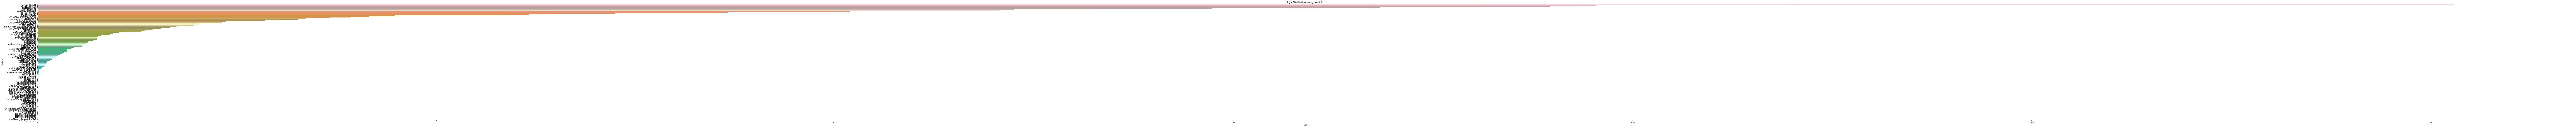

<Figure size 432x288 with 0 Axes>

In [144]:
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,train.columns)), columns=['Value','Feature'])
plt.figure(figsize=(200, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [145]:
params_xgb = {'colsample_bytree': 0.8,                 
              'learning_rate': 0.01,
              'max_depth': 8,
              'subsample': 0.8,
              'objective':'binary:logistic',
              'eval_metric':'auc',
              'n_estimators':5000,
              'verbosity':0
              }

In [120]:
import xgboost as xgb

columns = train.columns
splits = folds.split(train[feats], train['flag'])

oof_preds_xgb = np.zeros(train.shape[0])
sub_preds_xgb = np.zeros(test.shape[0])
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, X_valid = train[feats].iloc[train_index], train[feats].iloc[valid_index]
    y_train, y_valid = train['flag'].iloc[train_index], train['flag'].iloc[valid_index]
    
    train_set = xgb.DMatrix(X_train, y_train)
    val_set = xgb.DMatrix(X_valid, y_valid)
    test_set = xgb.DMatrix(test[feats])
    
    clf = xgb.train(params_xgb, train_set,num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], early_stopping_rounds=100, verbose_eval=100)
    
    oof_preds_xgb[valid_index] = clf.predict(val_set)
    sub_preds_xgb += clf.predict(test_set) / 5
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()


print('Full AUC score %.6f' % roc_auc_score(train['flag'], oof_preds_xgb))      

[0]	train-auc:0.72885	val-auc:0.69491
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100 rounds.
[100]	train-auc:0.82075	val-auc:0.74751
[200]	train-auc:0.85051	val-auc:0.75010
[300]	train-auc:0.87366	val-auc:0.75311
[400]	train-auc:0.88997	val-auc:0.75421
[500]	train-auc:0.90133	val-auc:0.75523
[600]	train-auc:0.90980	val-auc:0.75583
[700]	train-auc:0.91677	val-auc:0.75635
[800]	train-auc:0.92337	val-auc:0.75663
Stopping. Best iteration:
[774]	train-auc:0.92186	val-auc:0.75668

[0]	train-auc:0.73694	val-auc:0.69757
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100 rounds.
[100]	train-auc:0.82277	val-auc:0.74504
[200]	train-auc:0.85120	val-auc:0.74830
[300]	train-auc:0.87544	val-auc:0.75056
[400]	train-auc:0.89161	val-auc:0.75151
[500]	train-auc:0.90264	val-auc:0.75280
[600]	train-auc:0.91086	val-auc:0.75305
Stopping. Best it

In [91]:
test_id = test['id']
test_id

39923    U1E63A3
39924    U3EC77F
39925    U27DC0C
39926    U3FAAAC
39927    U04EA0B
          ...   
43918    U0FBFE2
43919    U506AD2
43920    U287B33
43921    U15134F
43922    U41D5EB
Name: id, Length: 4000, dtype: object

In [96]:
from scipy.stats import spearmanr
spearmanr(sub_preds,sub_preds_xgb)

SpearmanrResult(correlation=0.981649093399083, pvalue=0.0)

In [ ]:
print('Full AUC score %.6f' % roc_auc_score(train['flag'], 0.5*sub_preds + 0.5*sub_preds_xgb))  

In [92]:
print("Predicting the submission data...")

test['flag_xgb'] = sub_preds_xgb
test['flag'] = 0.5*sub_preds + 0.5*sub_preds_xgb


Predicting the submission data...


c:\users\work\miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\work\miniconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [93]:
test.head()

,id,flag,age,job_year,frs_agn_dt_cnt,l6mon_daim_aum_cd,bk1_cur_year_mon_avg_agn_amt_cd,l12mon_buy_fin_mng_whl_tms,l12_mon_fnd_buy_whl_tms,l12_mon_insu_buy_whl_tms,...,l1y_crd_card_csm_amt_dlm_cd_5,l1y_crd_card_csm_amt_dlm_cd_\N,l1y_crd_card_csm_amt_dlm_cd_nan,atdd_type_0.0,atdd_type_1.0,atdd_type_0,atdd_type_1,atdd_type_\N,atdd_type_nan,flag_xgb
39923,U1E63A3,0.209621,40,1,-1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0.210896
39924,U3EC77F,0.150155,46,3,-1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.144298
39925,U27DC0C,0.086462,42,3,-1,2,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0.079204
39926,U3FAAAC,0.096410,35,5,1180,3,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.089961
39927,U04EA0B,0.118229,34,9,1203,2,4,0,0,0,...,0,0,0,0,1,0,0,0,0,0.120418


In [94]:
np.savetxt(r'xgb.txt', test[['id','flag_xgb']].values, delimiter='\t',fmt = '%s')

In [95]:
np.savetxt(r'xgb_lgb.txt', test[['id','flag']].values, delimiter='\t',fmt = '%s')